# 다빈 kaggle 3번째 코드

#### 참조코드: https://www.kaggle.com/code/semihgnak/bankruptcy-perdiction-pca-smote-99-f1-score

#### kick point
- 데이터 전처리: <br>
    - 이상치 처리: outlier를 식별하고 적절한 값으로 대체
    - 변수 구분: 카테고리형과 수치형 변수를 분리하여 모델에 적합한 데이터 선택

- 표준화 및 차원축소

- 데이터 불균형 처리: <br>
    - SMOTE 사용: `BorderlineSMOTE`를 사용하여 불균형한 클래스 문제를 해결

- Modeling
    - `StackingClassifier`
    - `DecisionTreeClassifier`
    - `XGBClassifier`
    - `CatBoostClassifier`
    - `LGBMClassifier`
    - `KNeighborsClassifier`
    - `LogisticRegression`

사업 실패로 인한 파산은 기업뿐만 아니라 글로벌 경제에도 부정적인 영향을 미칠 수 있으므로 기업이 파산하는 증상을 보이고 있는지 이해하고 예측하는 것이 중요합니다. <br>
이 아이디어는 기업의 다양한 KPI를 고려하여 기업의 어려움을 분석하는 것입니다. <br>
이러한 어려움은 적절한 시기에 경고하지 않으면 종종 회사의 파산으로 이어집니다. <br>
문제 진술은 기업이 파산할 수 있는지 여부를 예측하는 예측 모델을 개발하는 것입니다. <br>
이는 회사가 적절한 결정을 내리는 데 도움이 될 것입니다.

In [28]:
%pip install feature_engine
%pip install lightgbm
%pip install yellowbrick
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, gc, joblib, re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, chi2, RFE, SequentialFeatureSelector
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
data = pd.read_csv('../../data/캐글_파산기업/data.csv')
df=data.copy()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [45]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    #print("##################### Head #####################")
    #print(dataframe.head(3))
    #print("##################### Tail #####################")
    #print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)

##################### Shape #####################
(6819, 96)
##################### Types #####################
Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object
##################### NA #####################
Bankrupt?                                                   0
 ROA(C

In [46]:
df.columns[df.nunique() == 1][0]

' Net Income Flag'

In [47]:
df.drop(df.columns[df.nunique() == 1][0],axis=1,inplace=True) # 데이터의 고유한 값이 1개인 열들을 찾아낸다. 즉, 값이 전부 같은 열을 선택하여 제거
df.columns = df.columns.str.replace(' ','')

In [48]:
 # DataFrame에서 변수(열)을 범주형 변수와 수치형 변수로 구분하고, 특수한 경우들을 처리하여 각 변수를 그룹화하는 함수
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # 범주형 변수로 간주할 최대 고유 값 개수 (기본값: 10). 예를 들어, 수치형 변수 중 고유 값이 10개 미만인 변수는 범주형으로 처리할 수 있다.
    # 카디널리티가 높은 변수로 간주할 최소 고유 값 개수 (기본값: 20). 카디널리티가 높은 범주형 변수는 일반적인 범주형 변수와 구분
    
    # 카디널리티(Cardinality)는 특정 데이터 집합의 유니크(Unique)한 값의 개수이다.
    # 즉, 중복도가 '낮으면' 카디널리티가 '높다'고 표현한다. 반대로 중복도가 '높으면' 카디널리티가 '낮다'고 표현
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] # 일반 범주형 변수를 찾아 저장

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"] # 숫자형 변수지만 고유 값이 적어서 범주형 변수처럼 간주할 수 있는 변수를 찾아 저장

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"] # 카디널리티가 높은 범주형 변수(고유 값이 많은 범주형 데이터)를 찾아 저장
    
    # 최종 범주형 변수 리스트 업데이트
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # 최종 수치형 변수 찾기
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 6819
Variables: 95
cat_cols: 2
num_cols: 93
cat_but_car: 0
num_but_cat: 2


In [49]:
# 이상치(outlier)를 탐지하는 함수
def outlier_thresholds(dataframe, variable, low_quantile=0.15, up_quantile=0.85):
    quantile_one = dataframe[variable].quantile(low_quantile) # low_quantile: 하위 사분위수를 결정하는 백분위 (기본값: 15%)
    quantile_three = dataframe[variable].quantile(up_quantile) # up_quantile: 상위 사분위수를 결정하는 백분위 (기본값: 85%)
    interquantile_range = quantile_three - quantile_one # IQR 계산
    up_limit = quantile_three + 1.5 * interquantile_range # 상한선 Q3 + 1.5 * IQR
    low_limit = quantile_one - 1.5 * interquantile_range # 하한선 Q1 - 1.5 * IQR
    return low_limit, up_limit

# 주어진 열(col_name)에서 이상치가 존재하는지 여부를 확인하는 함수
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        # .any(axis=None):이상치가 있으면 True, 없으면 False를 반환
        return True
    else:
        return False
for col in num_cols:
      col, check_outlier(df, col)
      # col, check_outlier(df, col)는 각 열의 이름과 함께 해당 열에 이상치가 존재하는지를 출력
      # ("age", True) → "age" 변수에서 이상치가 존재한다는 의미.

In [50]:
# 이상값 대체
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit # 하한선보다 작은 값에 대해서는 해당 값을 하한선 값으로 대체
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit # 상한선을 초과하는 값에 대해서는 해당 값을 상한선 값으로 대체


for col in num_cols:
    if col != "SalePrice": # SalePrice 열을 제외하고, 나머지 수치형 변수들에 대해서만 이상치 대체를 수행
        replace_with_thresholds(df,col)

In [51]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

In [52]:
# 특성 전처리 작업을 수행할 파이프라인을 정의
# 파이프라인은 연속된 전처리 단계들을 순서대로 수행할 수 있게 도와줌
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()), # 상수 특성(즉, 모든 샘플에서 값이 동일한 열)을 제거
    ('correlated',DropCorrelatedFeatures()), # 상관계수가 높은 상관된 특성들을 제거
    ('duplicate',DropDuplicateFeatures()) # 데이터셋 내에 중복된 특성이 있다면 이를 제거
])

X = pipeline.fit_transform(X)
X.shape

(6819, 55)

BorderlineSMOTE는 기존 SMOTE와 유사하게 작동하지만 몇 가지 주의 사항이 있습니다. SMOTE의 단점을 극복하기 위해 Noise와 Border라는 두 가지 포인트 세트를 식별합니다. <br>
가장 가까운 모든 이웃이 다른 클래스(대부분)에 속하는 경우 포인트를 "Noise"라고 합니다. <br>
반면에 "Border" 포인트는 과반수 및 소수 클래스 포인트가 가장 가까운 이웃으로 혼합된 포인트입니다.

![image.png](https://www.researchgate.net/publication/365584195/figure/fig2/AS:11431281098534768@1668976941016/Specific-groups-of-imbalanced-data-in-the-Borderline-SMOTE.png)

In [53]:
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 6599, 0: 6599})


In [54]:
from sklearn.preprocessing import RobustScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler() :RobustScaler는 중앙값(median)과 IQR을 사용해 데이터를 스케일링하므로, 이상치가 많은 데이터에서는 더 적합
scaled_train_X = scaler.fit_transform(X_train)


In [55]:
from sklearn.decomposition import PCA


pca=PCA()
pca.fit(scaled_train_X)
exp_variance = pca.explained_variance_ratio_ # 각 주성분이 전체 데이터의 분산 중 얼마나 많은 부분을 설명하는지를 나타냄
cum_exp_variance = np.cumsum(exp_variance) # 설명된 분산 비율의 누적 합을 계산
print(cum_exp_variance)
pca = PCA(n_components=27,random_state=7) # 분산 비율을 바탕으로, 주성분을 27개로 제한하여 사용. 데이터의 차원이 27차원으로 축소

train_pca = pca.fit_transform(scaled_train_X)

scaled_test_X = scaler.transform(X_test) # X_test를 훈련 데이터와 동일한 scaler를 사용하여 스케일링
# 훈련 데이터에서 학습한 기준(평균과 표준편차)을 기반으로 테스트 데이터를 변환해야 하므로, fit_transform()이 아닌 transform()을 사용
test_pca = pca.transform(scaled_test_X)

[0.22644219 0.33246487 0.39444329 0.44638198 0.48738019 0.52465357
 0.55688939 0.58578463 0.6132184  0.63752901 0.65887196 0.67919559
 0.69867365 0.71726644 0.73444109 0.75128099 0.76748112 0.78324214
 0.79833358 0.81244394 0.82632875 0.83896693 0.85102577 0.86224778
 0.87343669 0.88379566 0.89330472 0.90184407 0.91025372 0.91828597
 0.92611923 0.93278573 0.93916604 0.94456911 0.94955429 0.9542997
 0.95869814 0.96290858 0.96680127 0.97039885 0.97389854 0.97709051
 0.9801969  0.98308614 0.98573304 0.98827398 0.99049022 0.99241773
 0.99411747 0.99561707 0.99680157 0.99789786 0.99883583 0.99952889
 1.        ]


**fit**은 학습하는 단계이고, **transform**은 적용하는 단계

**1. 훈련 데이터에 대한 fit과 transform**
- fit: 데이터를 통해 패턴을 학습하는 단계입니다. PCA에서 이 패턴이란 **주성분(Principal Components)**을 찾는 과정입니다.

    - PCA는 훈련 데이터에서 가장 중요한 축을 찾고, 이 축을 기준으로 데이터의 차원을 축소합니다. <br>
    훈련 데이터를 학습하면서 이 축들을 구하기 때문에 훈련 데이터에 대해 fit을 수행합니다.

- transform: 학습한 PCA 모델을 사용하여 데이터를 주성분 축으로 변환하는 단계입니다. <br>
    - 주성분을 기준으로 데이터를 변환하여, 원래의 고차원 데이터를 축소된 저차원 데이터로 바꾸는 과정입니다. <br>
    즉, 훈련 데이터에서는 먼저 fit으로 학습을 하고, 학습한 PCA 모델을 이용해 데이터를 **transform**하여 변환합니다.

**2. 테스트 데이터에 대한 transform만 수행하는 이유** <br>
훈련 데이터를 사용해 이미 PCA 모델을 학습했기 때문에 테스트 데이터는 학습한 모델에 맞춰 변환만 해야 합니다. <br>
다시 새로운 주성분을 학습할 필요가 없습니다. <br>
테스트 데이터에 대해 fit을 수행하면 PCA는 훈련 데이터와 다른 주성분을 찾을 수 있으며, 이것은 모델의 일관성을 깨뜨립니다. <br>
따라서 테스트 데이터에 대해서는 훈련 데이터에서 이미 학습한 주성분을 기준으로 변환하는 **transform**만 수행하는 것입니다.

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1320
           1       0.90      0.95      0.92      1320

    accuracy                           0.92      2640
   macro avg       0.92      0.92      0.92      2640
weighted avg       0.92      0.92      0.92      2640

--------------------------------------------------


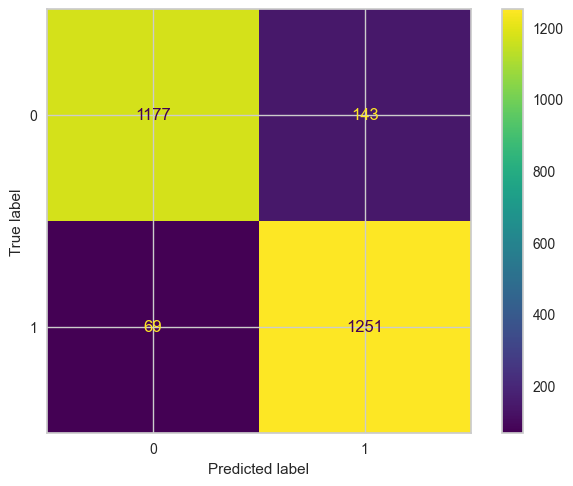

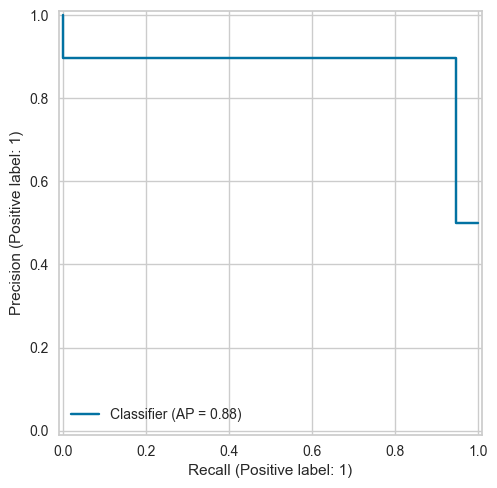

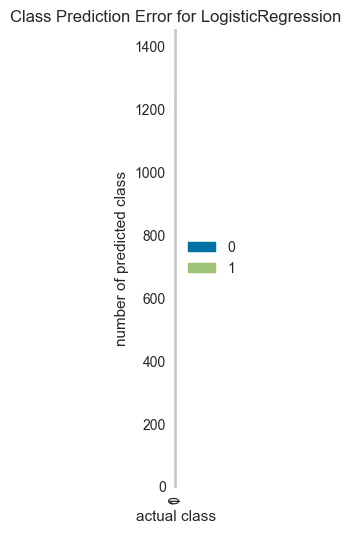

This is not a CatBoost model.


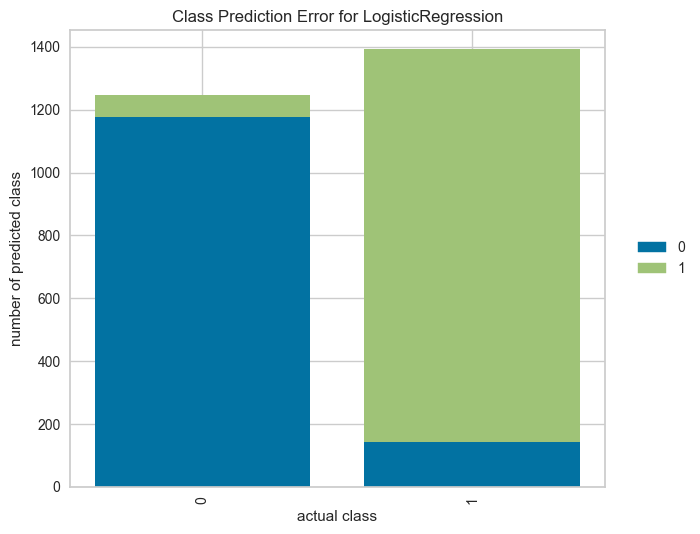

In [63]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def train_and_evaluate_model(model):
    model.fit(train_pca,y_train)
    y_pred = model.predict(test_pca)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred) # 혼동 행렬(Confusion Matrix) 시각화
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred) # Precision-Recall Curve와 ROC Curve 시각화

    # 성능 지표 계산 및 저장
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')
    
    # yellowbrick 라이브러리의 ClassPredictionError 시각화 도구를 사용하여 모델의 예측 성능을 분석합니다.
    # CatBoost 모델이 아닐 경우에만 이 도구를 사용
    # visualizer.score()는 테스트 데이터를 입력받아 시각화를 생성하며, 이후 메모리 해제를 위해 del visualizer를 사용
    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.fit(train_pca, y_train)
        visualizer.score(test_pca,y_test)
        visualizer.show()
        del visualizer
    
    if re.search('catboost', str(model)) == None:
        print("This is not a CatBoost model.")
        visualizer = ClassPredictionError(model)
        visualizer.fit(train_pca, y_train)  # 훈련 데이터로 적합
        visualizer.score(test_pca, y_test)  # 테스트 데이터로 점수 계산 및 시각화
        visualizer.show()
        del visualizer
        
    # 각 성능 지표는 리스트에 저장    
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)

    # 사용이 끝난 변수를 삭제하고 Garbage Collection을 호출하여 메모리 누수를 방지
    del acc, precision, recall, f1, roc_auc
    gc.collect()

# Logistic Regression 모델을 사용하여 훈련하고, 평가 및 시각화를 진행
train_and_evaluate_model(LogisticRegression())

> 마지막 시각화 그림(이렇게 시각화해야 제대로 나옴): <br>
Logistic Regression 모델의 Class Prediction Error를 보여주는 그래프
- Y축 (number of predicted class): 모델이 예측한 클래스의 개수
- X축 (actual class): 실제 클래스 값입니다. 0은 파산하지 않은 기업을, 1은 파산한 기업을 의미

1. **클래스 0 (파란색):**

- 실제 클래스 0(파산하지 않음)에 해당하는 샘플들이 대부분 정확하게 예측되었음을 보여준다. <br>
하지만 일부는 클래스 1로 잘못 예측된 경우도 있습니다. 즉, 실제로 파산하지 않은 기업이 파산한 것으로 잘못 예측된 경우도 보인다 <br>

2. **클래스 1 (녹색):**

- 실제 클래스 1(파산)에 해당하는 샘플들에 대한 예측 <br>
이 경우도 일부는 정확하게 예측되었지만, 실제 파산한 기업 중 일부가 클래스 0으로 잘못 예측되었습니다. 즉, 실제로 파산한 기업을 파산하지 않은 것으로 예측한 경우

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.95      1320
           1       0.92      1.00      0.96      1320

    accuracy                           0.96      2640
   macro avg       0.96      0.96      0.96      2640
weighted avg       0.96      0.96      0.96      2640

--------------------------------------------------


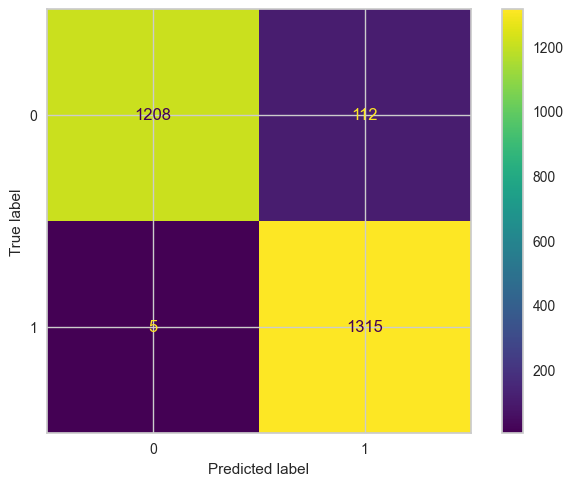

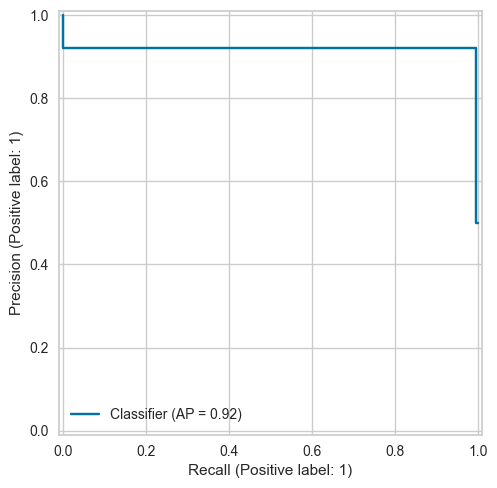

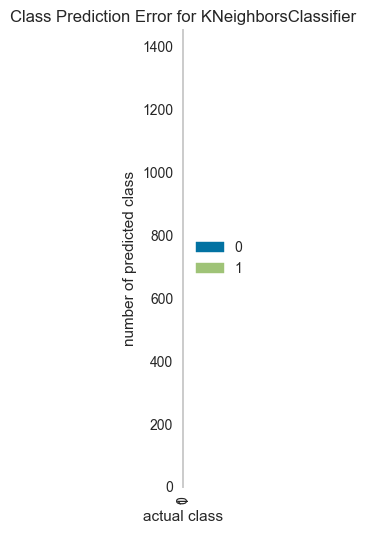

This is not a CatBoost model.


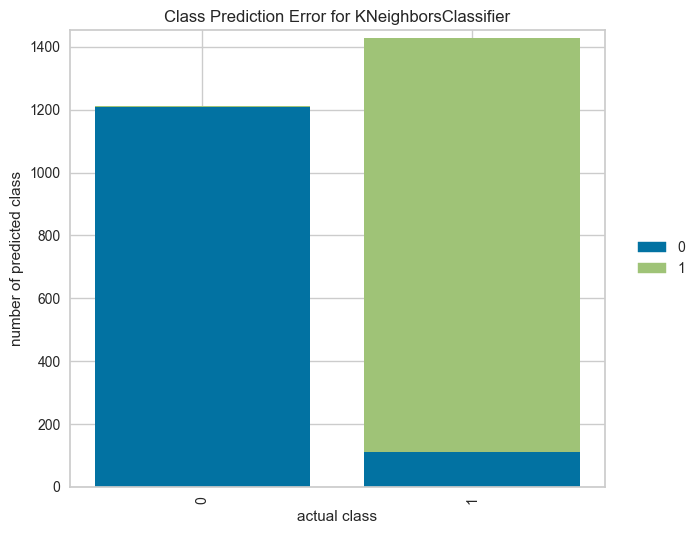

In [64]:
train_and_evaluate_model(KNeighborsClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.98      0.99      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640

--------------------------------------------------


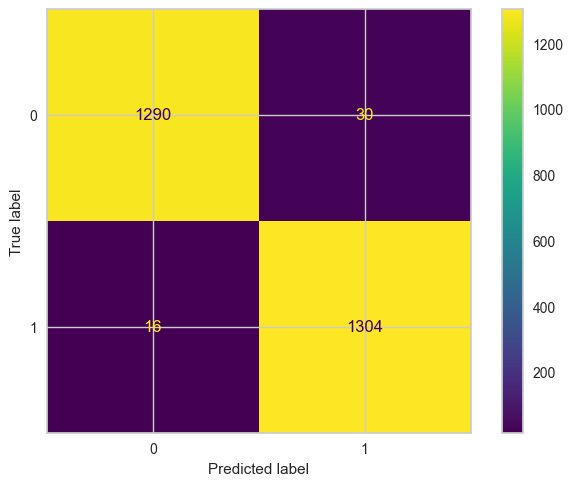

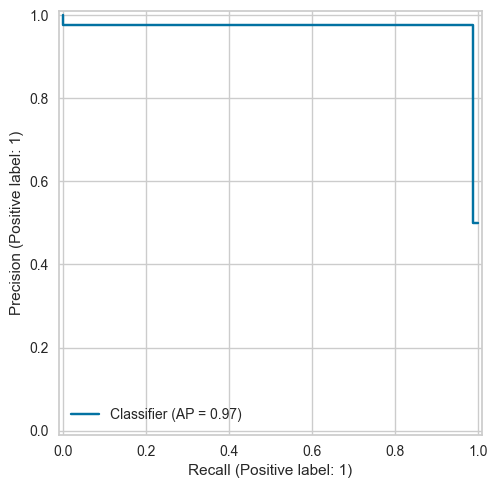

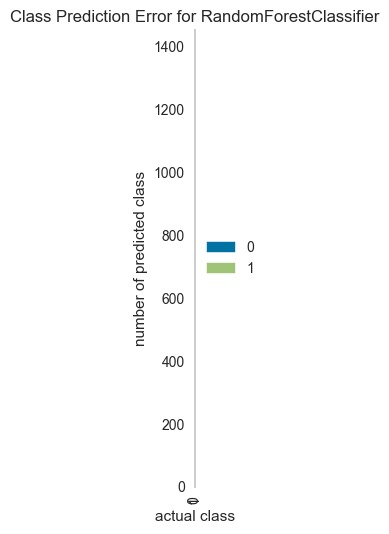

This is not a CatBoost model.


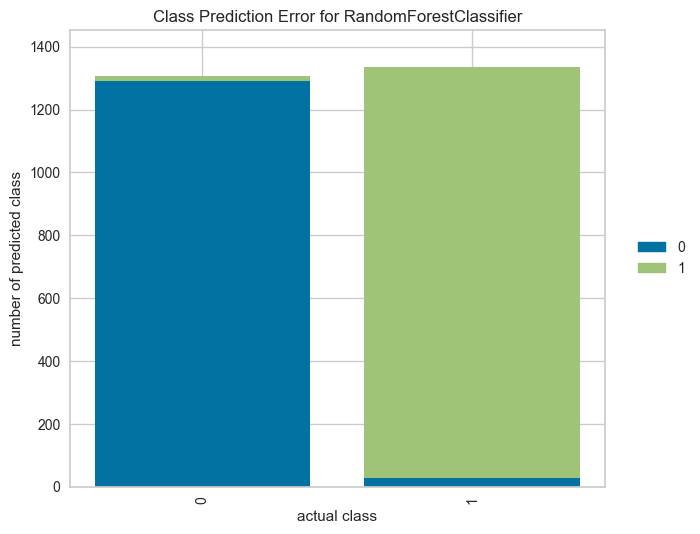

In [65]:
train_and_evaluate_model(RandomForestClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.97      0.99      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640

--------------------------------------------------


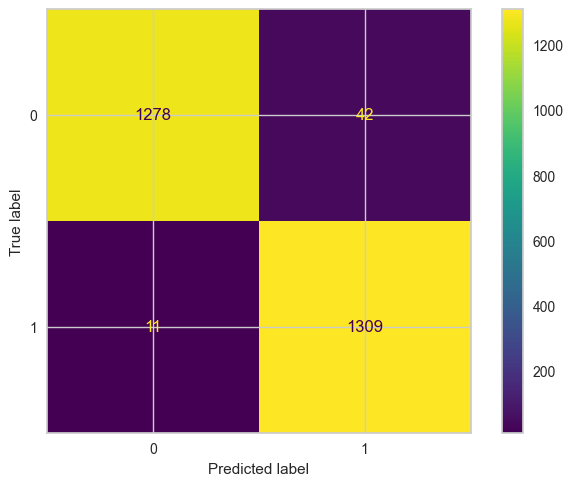

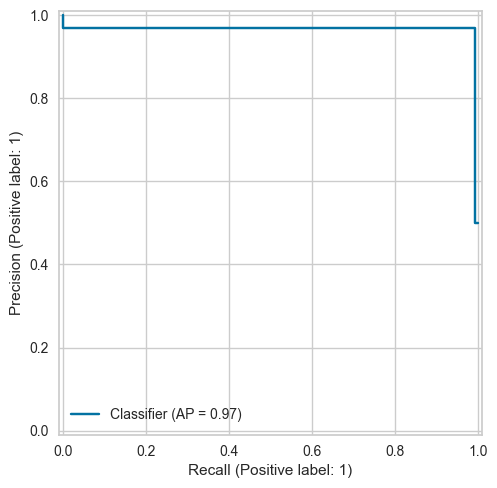

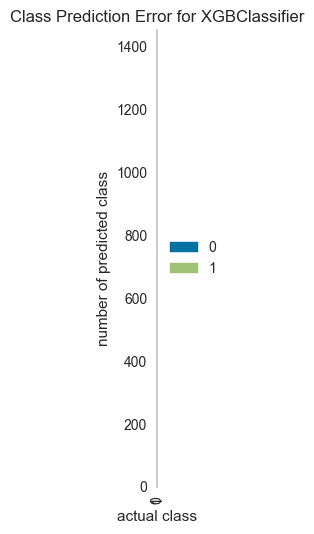

This is not a CatBoost model.


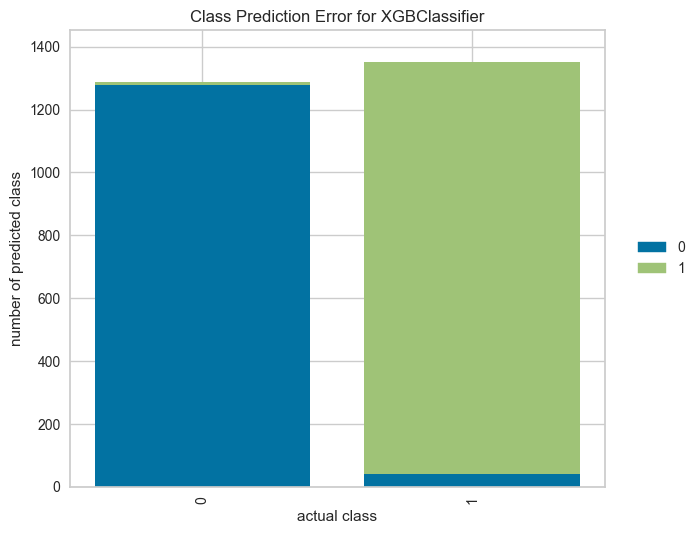

In [66]:
train_and_evaluate_model(XGBClassifier())

[LightGBM] [Info] Number of positive: 5279, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 10558, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1320
           1       0.96      0.99      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640

--------------------------------------------------


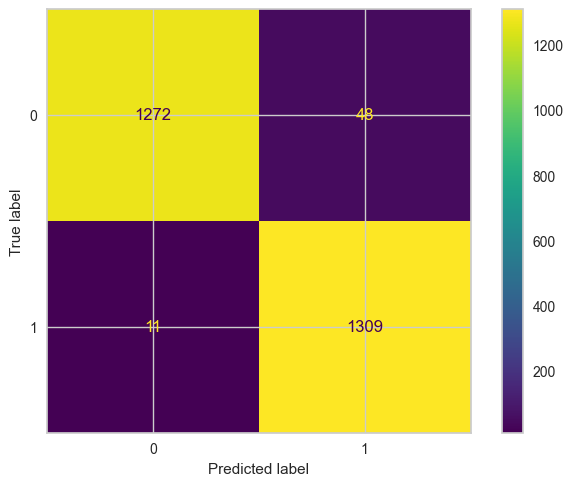

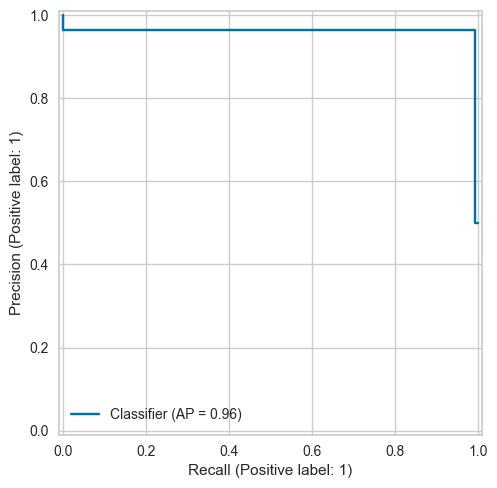

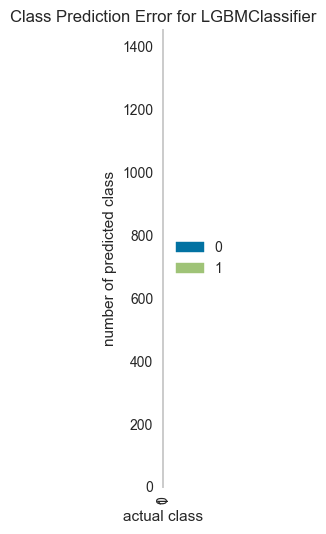

This is not a CatBoost model.


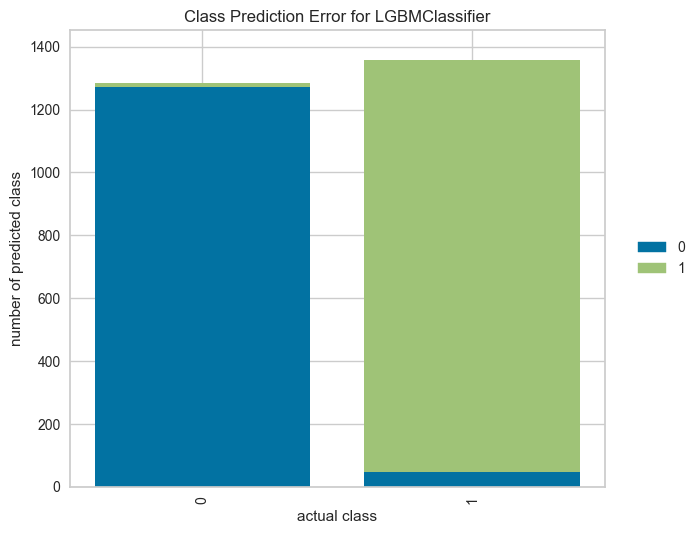

In [67]:
train_and_evaluate_model(LGBMClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.97      0.99      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640

--------------------------------------------------


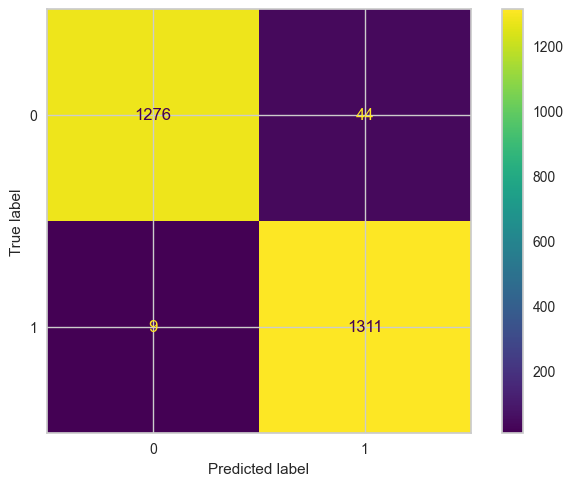

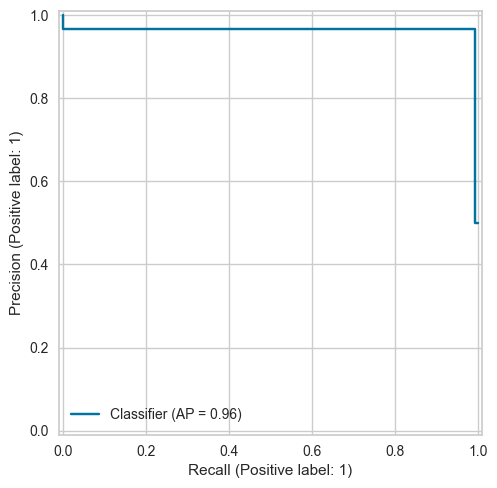

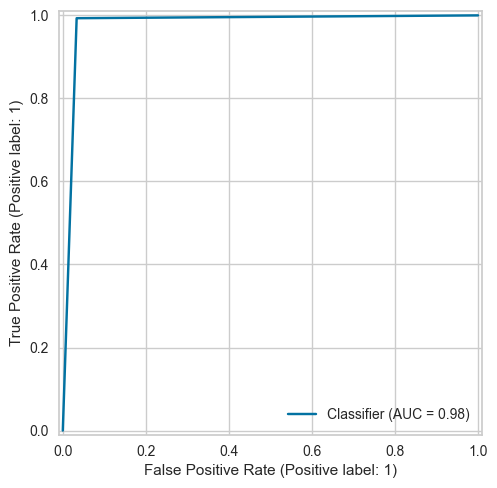

In [68]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

# silent=True: CatBoost 모델은 기본적으로 학습 중간에 훈련 과정을 출력하는데,
# 이를 비활성화하려면 silent=True로 설정하여 콘솔 출력을 끄게 됩니다. 
# 즉, 훈련 중에 출력되는 정보를 숨기는 역할을 합니다.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1320
           1       0.99      0.99      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640

--------------------------------------------------


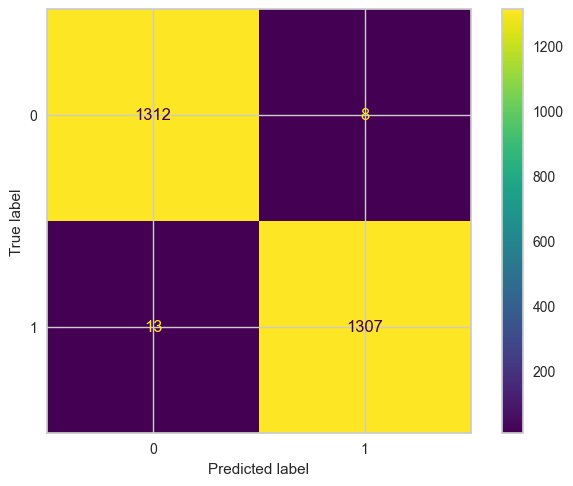

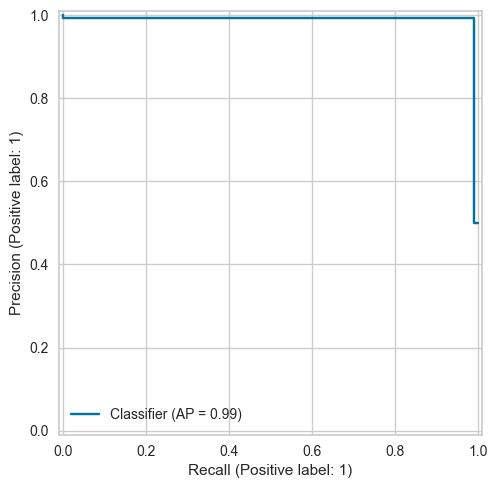

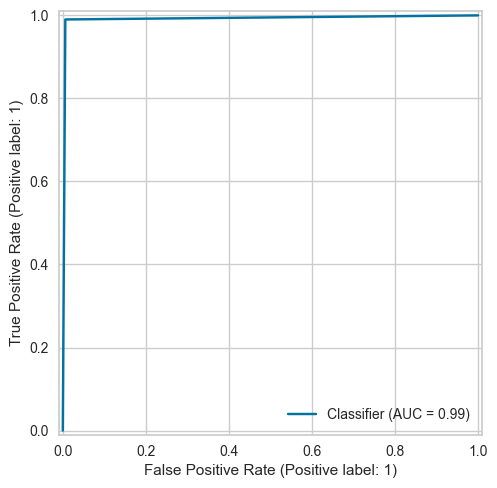

In [69]:
train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],final_estimator=RandomForestClassifier(),verbose=2))

1. **StackingClassifier:**
- `Stacking`은 여러 다른 머신러닝 모델의 예측을 결합하여 성능을 향상시키는 방법으로 각 모델의 예측 결과를 기반으로 최종 모델(final estimator)을 훈련시킵니다.

2. **estimators:**

- 이 매개변수는 여러 기본 모델을 리스트 형태로 정의하며 여기에서는 다음과 같은 세 개의 기본 모델이 사용되고 있습니다:
    - ('ET', ExtraTreesClassifier()): 랜덤 포레스트와 유사하지만, 더욱 많은 트리를 사용하여 더 안정적이고 강력한 예측을 생성하는 Extra Trees 분류기.
    - ('XGB', XGBClassifier()): XGBoost 분류기로, Gradient Boosting 알고리즘의 한 종류로 성능이 뛰어난 모델입니다.
    - ('CAT', CatBoostClassifier(silent=True)): CatBoost 분류기로, 카테고리형 변수를 잘 처리하고 성능이 뛰어난 Gradient Boosting 모델입니다. silent=True는 출력 메시지를 줄여줍니다.

3. **final_estimator:**
- 최종 예측을 수행할 모델을 지정합니다. 여기서는 RandomForestClassifier()가 사용되었습니다. 기본 모델의 예측 결과를 기반으로 최종 예측을 생성하는 데 사용됩니다.

In [70]:
model_perfs = pd.DataFrame({'Model': models, 
                            'Accuracy': accuracy_scores, 
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,"StackingClassifier(estimators=[('ET', ExtraTre...",0.992045,0.992053,0.992045,0.992045,0.992045
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.982576,0.982630,0.982576,0.982575,0.982576
2,"XGBClassifier(base_score=None, booster=None, c...",0.979924,0.980189,0.979924,0.979921,0.979924
3,<catboost.core.CatBoostClassifier object at 0x...,0.979924,0.980262,0.979924,0.979921,0.979924
4,LGBMClassifier(),0.977652,0.978027,0.977652,0.977647,0.977652
5,KNeighborsClassifier(),0.955682,0.958696,0.955682,0.955609,0.955682
6,LogisticRegression(),0.919697,0.921020,0.919697,0.919634,0.919697
